In [39]:
import math
import os

import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from torch.autograd import Function
from torch.nn import init, Module, functional
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [40]:
!gdown --id 1-D6l7Z_4-I4-eMHUrHSXN8evrj09M9el

Downloading...
From: https://drive.google.com/uc?id=1-D6l7Z_4-I4-eMHUrHSXN8evrj09M9el
To: /content/ZCA_params.npy
100% 151M/151M [00:00<00:00, 164MB/s]


In [41]:


# For Training
batch_size = 50
num_epochs = 10

# For batchnorm
epsilon = 1e-4
alpha = .1

# For the optimizer
learning_rate = .003
min_learning_rate = 2e-6
decay = (min_learning_rate / learning_rate) ** (1. / num_epochs)
weight_decay = 2e-4

# Set GPU
device = torch.device("cuda")

# To save model
save_model = True
PATH = 'CIFAR10_ZCA.pt'

In [42]:
!mkdir /content/drive/MyDrive/weights/

mkdir: cannot create directory ‘/content/drive/MyDrive/weights/’: No such file or directory


In [43]:
with open("ZCA_params.npy", "rb") as f:
    U = np.load(f)
    S = np.load(f)
    V = np.load(f)

zca_epsilon = 0.1
pre_compute = U.dot(np.diag(1.0 / np.sqrt(S + zca_epsilon))).dot(U.T)

pre_compute = torch.from_numpy(pre_compute).float().to(device)
print(pre_compute.shape)

def apply_ZCA(x_train):
    global pre_compute
    # X_norm = x_train.cpu().reshape((x_train.shape[0], -1)).numpy()
    X_norm = x_train.reshape((x_train.shape[0], -1)).float()
    X_ZCA = pre_compute.matmul(X_norm.T).T
    # X_ZCA = torch.tensor(X_ZCA)
    return X_ZCA.reshape_as(x_train)

torch.Size([3072, 3072])


In [44]:
class nn(Module):
    def __init__(self):
        super(nn, self).__init__()

        self.c3_128_1 = torch.nn.Conv2d(3, 128, 3, padding=1)
        self.bn_1 = torch.nn.BatchNorm2d(128, eps=epsilon, momentum=alpha)

        self.c3_128_2 = torch.nn.Conv2d(128, 128, 3, padding=1)
        self.mp2_2 = torch.nn.MaxPool2d(2)
        self.bn_2 = torch.nn.BatchNorm2d(128, eps=epsilon, momentum=alpha)

        self.c3_256_3 = torch.nn.Conv2d(128, 256, 3, padding=1)
        self.bn_3 = torch.nn.BatchNorm2d(256, eps=epsilon, momentum=alpha)

        self.c3_256_4 = torch.nn.Conv2d(256, 256, 3, padding=1)
        self.mp2_4 = torch.nn.MaxPool2d(2)
        self.bn_4 = torch.nn.BatchNorm2d(256, eps=epsilon, momentum=alpha)

        self.c3_512_5 = torch.nn.Conv2d(256, 512, 3, padding=1)
        self.bn_5 = torch.nn.BatchNorm2d(512, eps=epsilon, momentum=alpha)

        self.c3_512_6 = torch.nn.Conv2d(512, 512, 3, padding=1)
        self.mp2_6 = torch.nn.MaxPool2d(2)
        self.bn_6 = torch.nn.BatchNorm2d(512, eps=epsilon, momentum=alpha)

        self.d_1024_7 = torch.nn.Linear(2048 * 4, 1024)
        self.bn_7 = torch.nn.BatchNorm1d(1024, eps=epsilon, momentum=alpha)
        
        self.d_1024_8 = torch.nn.Linear(1024, 1024)
        self.bn_8 = torch.nn.BatchNorm1d(1024, eps=epsilon, momentum=alpha)

        self.d_10_9 = torch.nn.Linear(1024, 10)
        self.bn_9 = torch.nn.BatchNorm1d(10, eps=epsilon, momentum=alpha)

    def forward(self, input):
        x = self.c3_128_1(input)
        x = torch.nn.ReLU()(self.bn_1(x))
#         print(x.shape)
        x = self.c3_128_2(x)
        x = self.mp2_2(x)
        x = torch.nn.ReLU()(self.bn_2(x))
#         print(x.shape)

        x = self.c3_256_3(x)
        x = torch.nn.ReLU()(self.bn_3(x))
#         print(x.shape)
        x = self.c3_256_4(x)
        x = self.mp2_4(x)
        x = torch.nn.ReLU()(self.bn_4(x))
#         print(x.shape)

        x = self.c3_512_5(x)
        x = torch.nn.ReLU()(self.bn_5(x))
#         print(x.shape)
        x = self.c3_512_6(x)
        x = self.mp2_6(x)
        x = torch.nn.ReLU()(self.bn_6(x))
#         print(x.shape)

        x = torch.nn.Flatten()(x)
        
        x = self.d_1024_7(x)
        x = torch.nn.ReLU()(self.bn_7(x))
#         print(x.shape)

        x = self.d_1024_8(x)
        x = torch.nn.ReLU()(self.bn_8(x))
#         print(x.shape)

        x = self.d_10_9(x)
        x = self.bn_9(x)
        # x = torch.nn.Softmax(-1)(x)
        return x

In [45]:
model = nn().to(device)

In [46]:
model

nn(
  (c3_128_1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_2): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_256_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_256_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn_4): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
  (c3_512_5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_5): BatchNorm2d(512, eps=0.0001, momentum=

In [47]:
t = transforms.Compose(
    [
       transforms.ToTensor(),
    
    ]
)

dl_train = DataLoader(
    torchvision.datasets.CIFAR10(
        "/data/cifar",
        download=True,
        train=True,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x: torch.LongTensor([x]), # or just torch.tensor
            lambda x: torch.nn.functional.one_hot(x, 10),
            lambda x: 2*x - 1 
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)
dl_test = DataLoader(
    torchvision.datasets.CIFAR10(
        "/data/cifar",
        download=True,
        train=False,
        transform=t,
        target_transform=torchvision.transforms.Compose([
            lambda x:torch.LongTensor([x]), # or just torch.tensor
            lambda x:torch.nn.functional.one_hot(x, 10),
            lambda x: 2*x - 1 
        ])
    ),
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
def sqr_hinge_loss_2(output,target): 
    zero = torch.Tensor([0]).to(device)
    result = torch.max(zero, 1 - output*target)**2
    #print('result: ', result)
    mean_loss = torch.mean(torch.mean(result))
    #print('mean_loss: ',mean_loss)
    return mean_loss

In [49]:

loss = sqr_hinge_loss_2
optim_list = []
for child in model.children():
    if child is model.d_10_9:
        optim_list.append(
            {
                'params': child.parameters(), 
                'lr': learning_rate,
                'weight_decay': weight_decay,
            }
        ) 
    else:
        optim_list.append(
            {
                'params': child.parameters(), 
                'lr': learning_rate,
                # 'weight_decay': weight_decay, # Added for testing
            }
        )

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay)

In [50]:
def train(model, num_epochs, dl_train, dl_valid, optimizer, lossfunction, lr_scheduler=None):
    global PATH, save_model

    losses = []
    val_losses = []
    accuracy = []
    best_accuracy = 0
    total_steps = len(dl_train) * num_epochs

    try:
        for epoch in range(num_epochs):
            losses.append(0)
            val_losses.append(0)
            accuracy.append(0)
            print(f"Epoch {epoch + 1}")
            # Start training
            model.train()
            for i, (input, target) in enumerate(dl_train):
                if i % 10 == 0:
                    print(i, end=" ")
                if (i+1) % 150 == 0:
                    print()
                optimizer.zero_grad()

                input = input.to(device)
                input = apply_ZCA(input)
                target = torch.reshape(target, (-1, 10)).to(device)
                output = model(input)
                
                loss = lossfunction(output, target.float())
                
                losses[epoch] += loss.item()
                loss.backward()
                
                optimizer.step()
            #break
            model.eval()
            tot_acc = 0
            with torch.no_grad():
                for j, (input, target) in enumerate(dl_valid):
                    input = input.to(device)
                    input = apply_ZCA(input)
                    target = target.reshape((-1, 10)).to(device)
                    output = model(input)
                    
                    loss = lossfunction(output, target.float())
                    #loss = sqr_hinge_loss_2(output, target.float())
                    val_losses[epoch] += loss.item()
                    tot_acc = (tot_acc * j + int(sum(torch.argmax(target, -1) == torch.argmax(output, -1))) / target.shape[0]) / (j + 1)
            
            accuracy[epoch] = tot_acc

            print("")
            print("Epoch training loss" , losses[epoch] / len(dl_train))
            print("Epoch valid loss" , val_losses[epoch] / len(dl_valid))
            print("Validation Accuracy:", tot_acc)
            if lr_scheduler is not None:
                lr_scheduler.step()

            if save_model:
                if accuracy[epoch] > best_accuracy:
                    torch.save(
                        {
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'losses': losses,
                            'lr_scheduler': lr_scheduler.state_dict() if lr_scheduler is not None else None,
                            'accuracy': accuracy,
                            'val_losses': val_losses,
                        },
                        PATH,
                    )
                    best_accuracy = accuracy[epoch]
                    print("Saved weights")
                print(f"Best accuracy: {best_accuracy}\n")

    except KeyboardInterrupt:
        pass
    return epoch, losses, val_losses, accuracy

In [51]:
epoch, losses, val_losses, accuracy = train(model, num_epochs, dl_train, dl_test, optimizer, loss)

Epoch 1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 
150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 
300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 
450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 
600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 
750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
900 910 920 930 940 950 960 970 980 990 
Epoch training loss 0.3700834688693285
Epoch valid loss 0.17492547001689673
Validation Accuracy: 0.6788999999999997
Saved weights
Best accuracy: 0.6788999999999997

Epoch 2
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 
150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 
300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 
450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 
600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 
750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 
900 910 920 930 940 950 960 970 980 990 
Epoch training loss 0.14496

In [52]:
import matplotlib.pyplot as plt

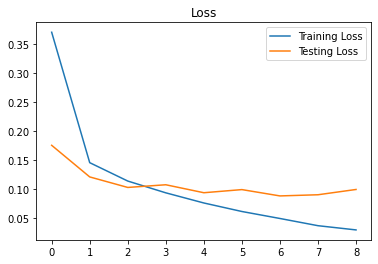

In [53]:
plt.title("Loss")
plt.plot([loss / len(dl_train) for loss in losses[:-1]], label="Training Loss") 
plt.plot([val_loss / len(dl_test) for val_loss in val_losses[:-1]], label="Testing Loss")
plt.legend()
plt.show()

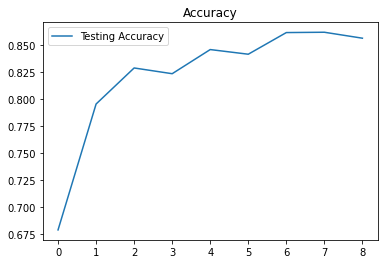

In [54]:
plt.title("Accuracy")
plt.plot(accuracy[:-1], label="Testing Accuracy")
plt.legend()
plt.show()

In [55]:
max(accuracy)

0.8614999999999999